In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

df = pd.read_csv('merged_cleaned.csv', encoding='latin1')

In [2]:
# Basic Information
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Followers                          930 non-null    int64  
 1   Average_Likes                      930 non-null    float64
 2   Average_Comments                   930 non-null    float64
 3   Average_Engagement_Rate            930 non-null    float64
 4   Engagement_Rate_(60_Days)          930 non-null    float64
 5   Posting_frequency_(last_60_days)   930 non-null    float64
 6   Posts_(image)                      930 non-null    float64
 7   Posts_(videos)                     930 non-null    float64
 8   Posts_(carousel)                   930 non-null    float64
 9   Average_Hashtags_/_Post_(60_Days)  930 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 72.8 KB
None
          Followers  Average_Likes  Average_Comments  Average_Engagemen

In [3]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
print("Numeric Columns:", numeric_cols)


Numeric Columns: Index(['Followers', 'Average_Likes', 'Average_Comments',
       'Average_Engagement_Rate', 'Engagement_Rate_(60_Days)',
       'Posting_frequency_(last_60_days)', 'Posts_(image)', 'Posts_(videos)',
       'Posts_(carousel)', 'Average_Hashtags_/_Post_(60_Days)'],
      dtype='object')


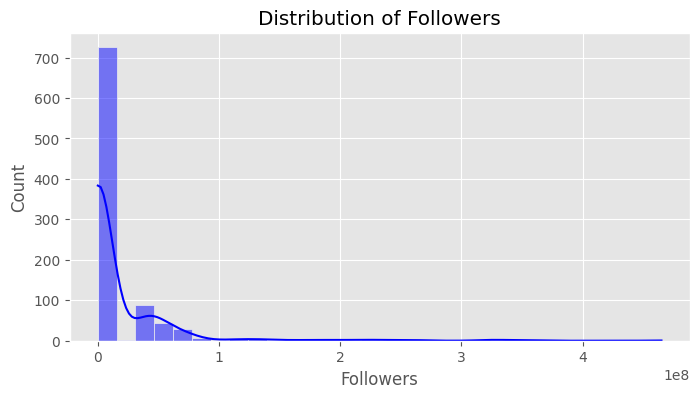

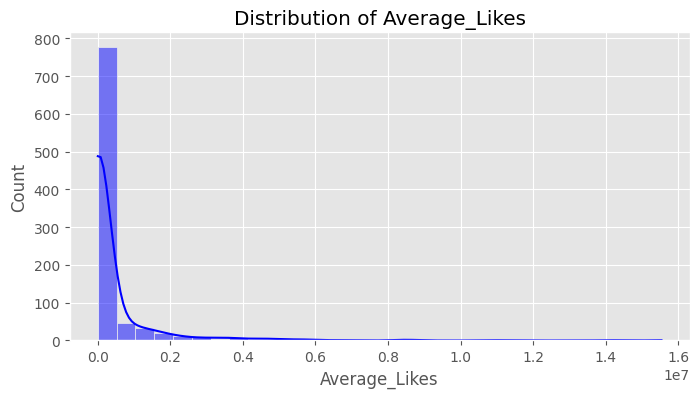

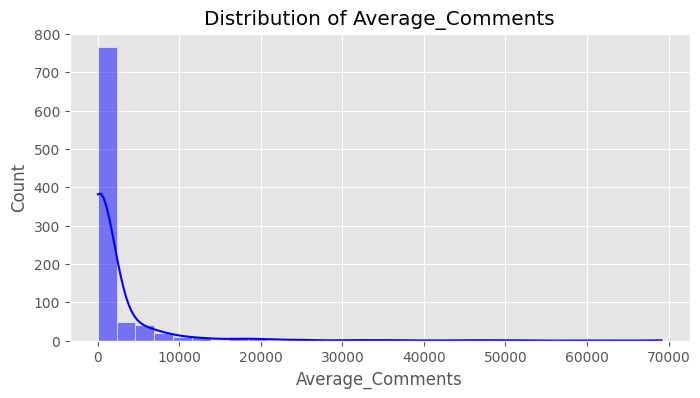

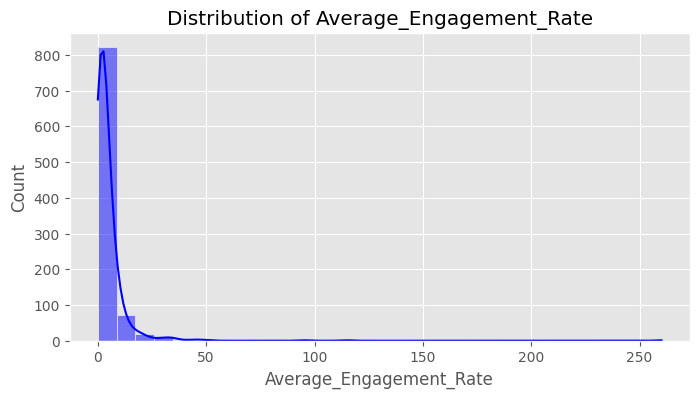

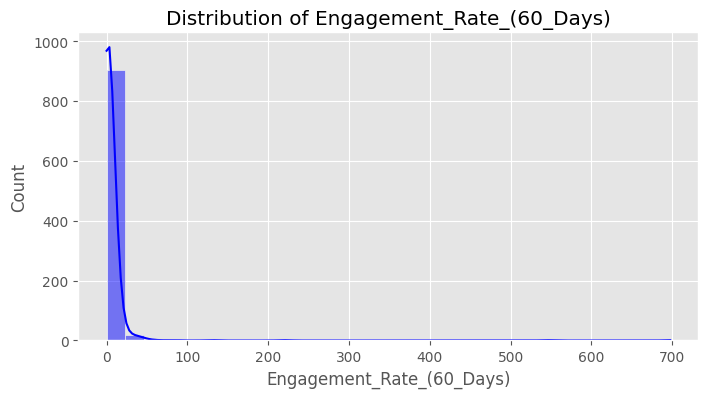

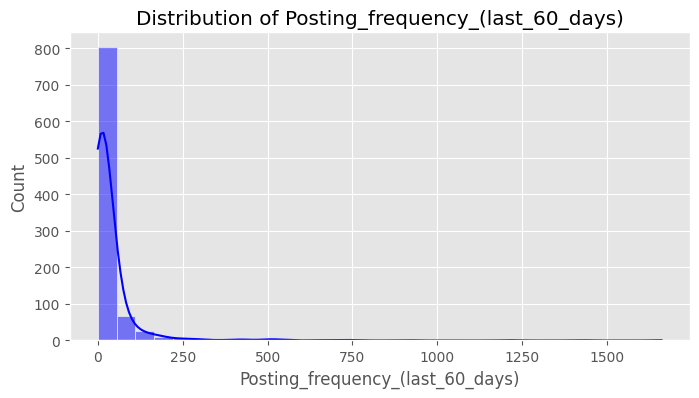

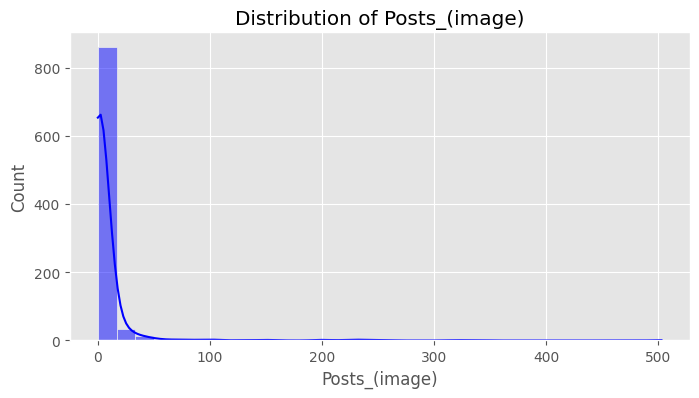

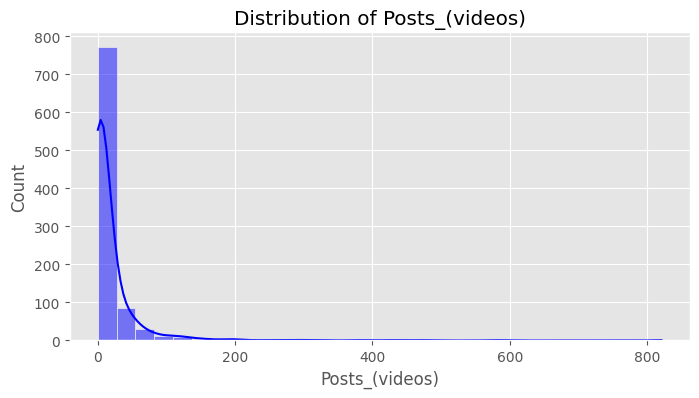

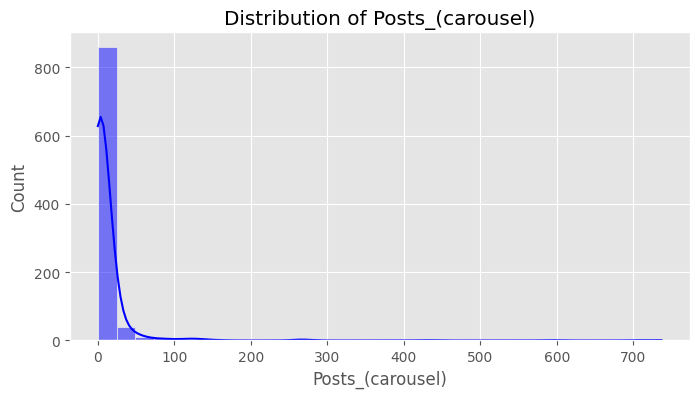

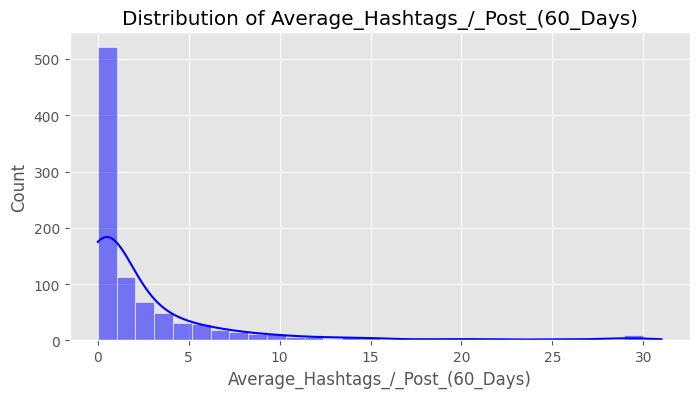

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot all numeric columns
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    plt.show()


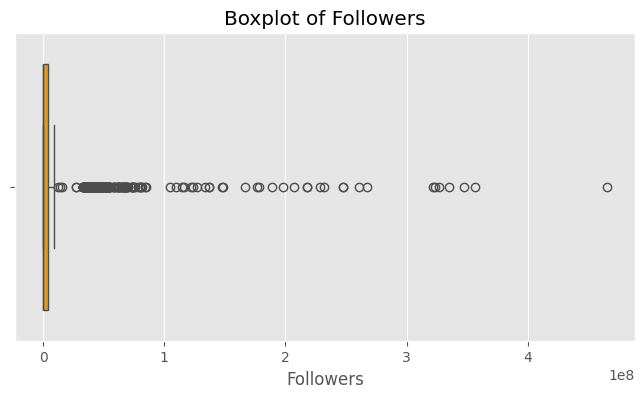

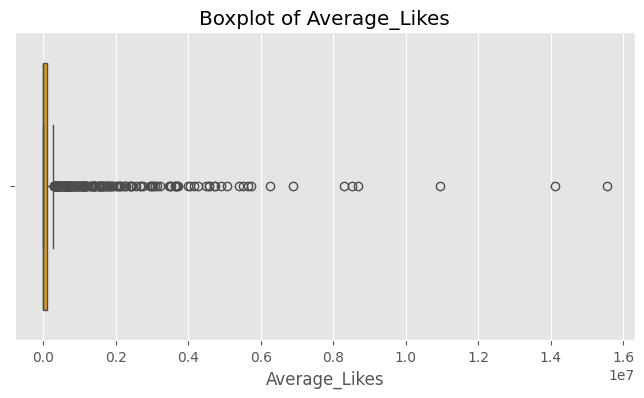

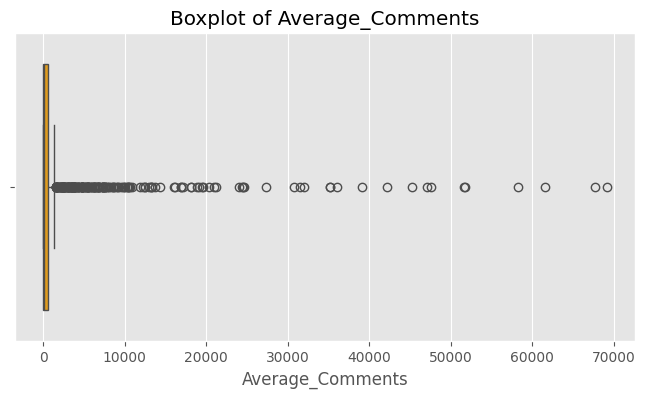

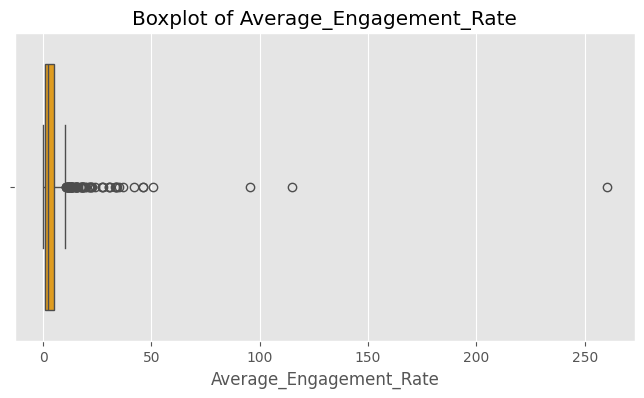

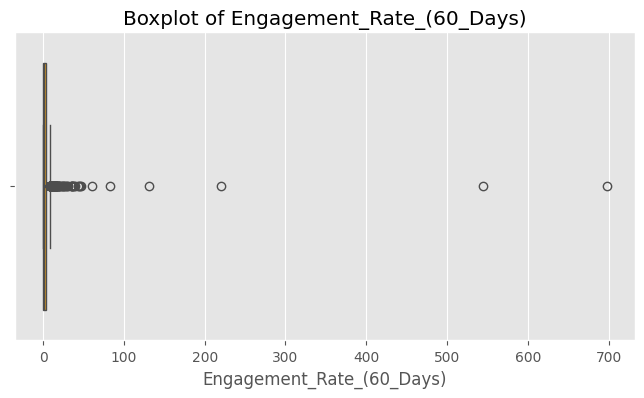

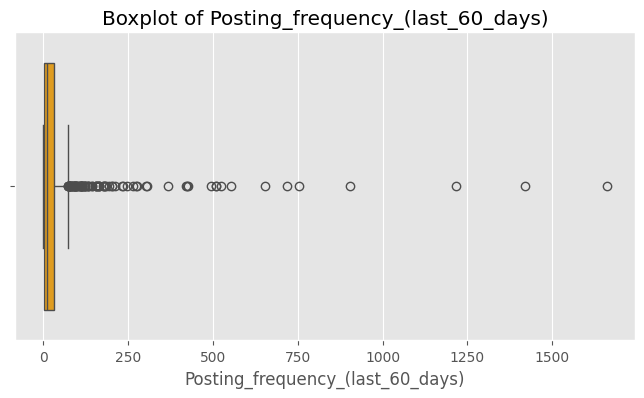

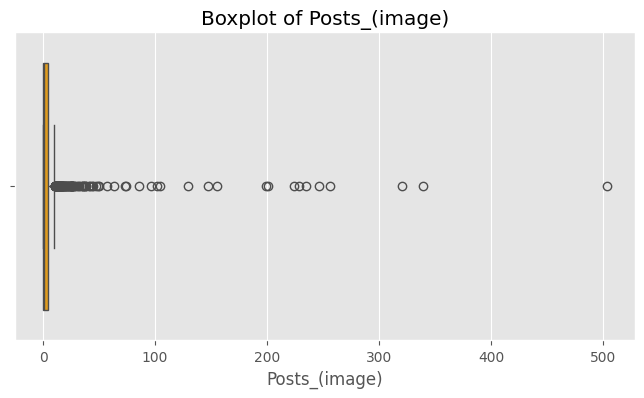

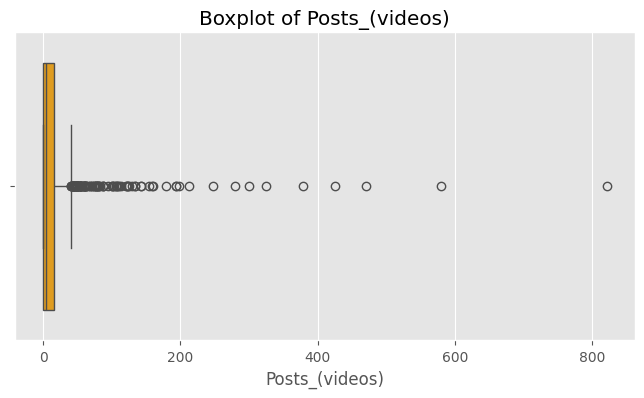

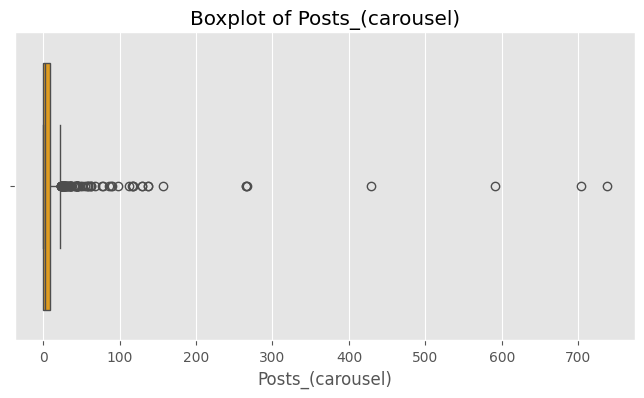

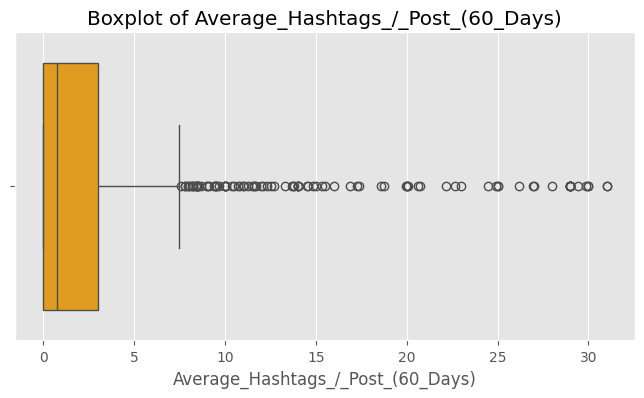

In [6]:
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col, color='orange')
    plt.title(f'Boxplot of {col}')
    plt.show()


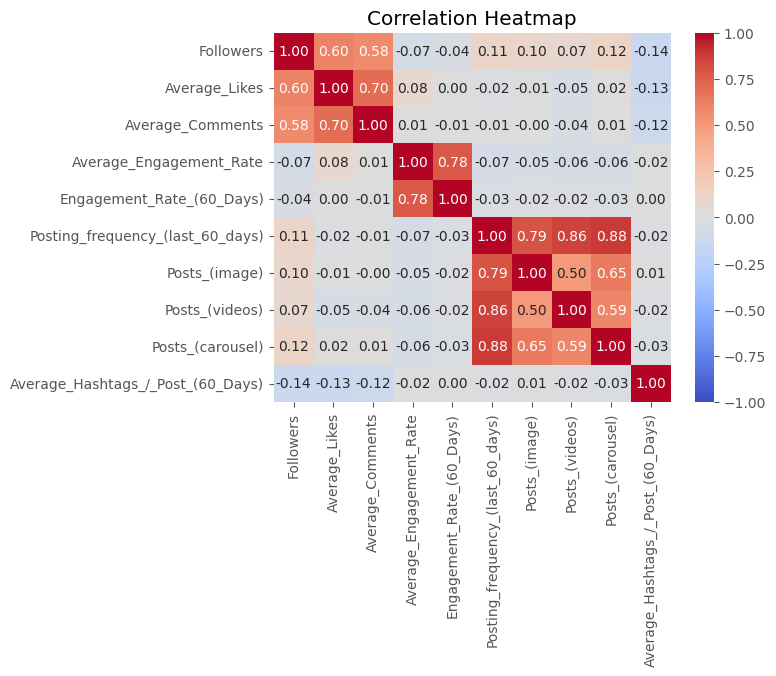

In [7]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


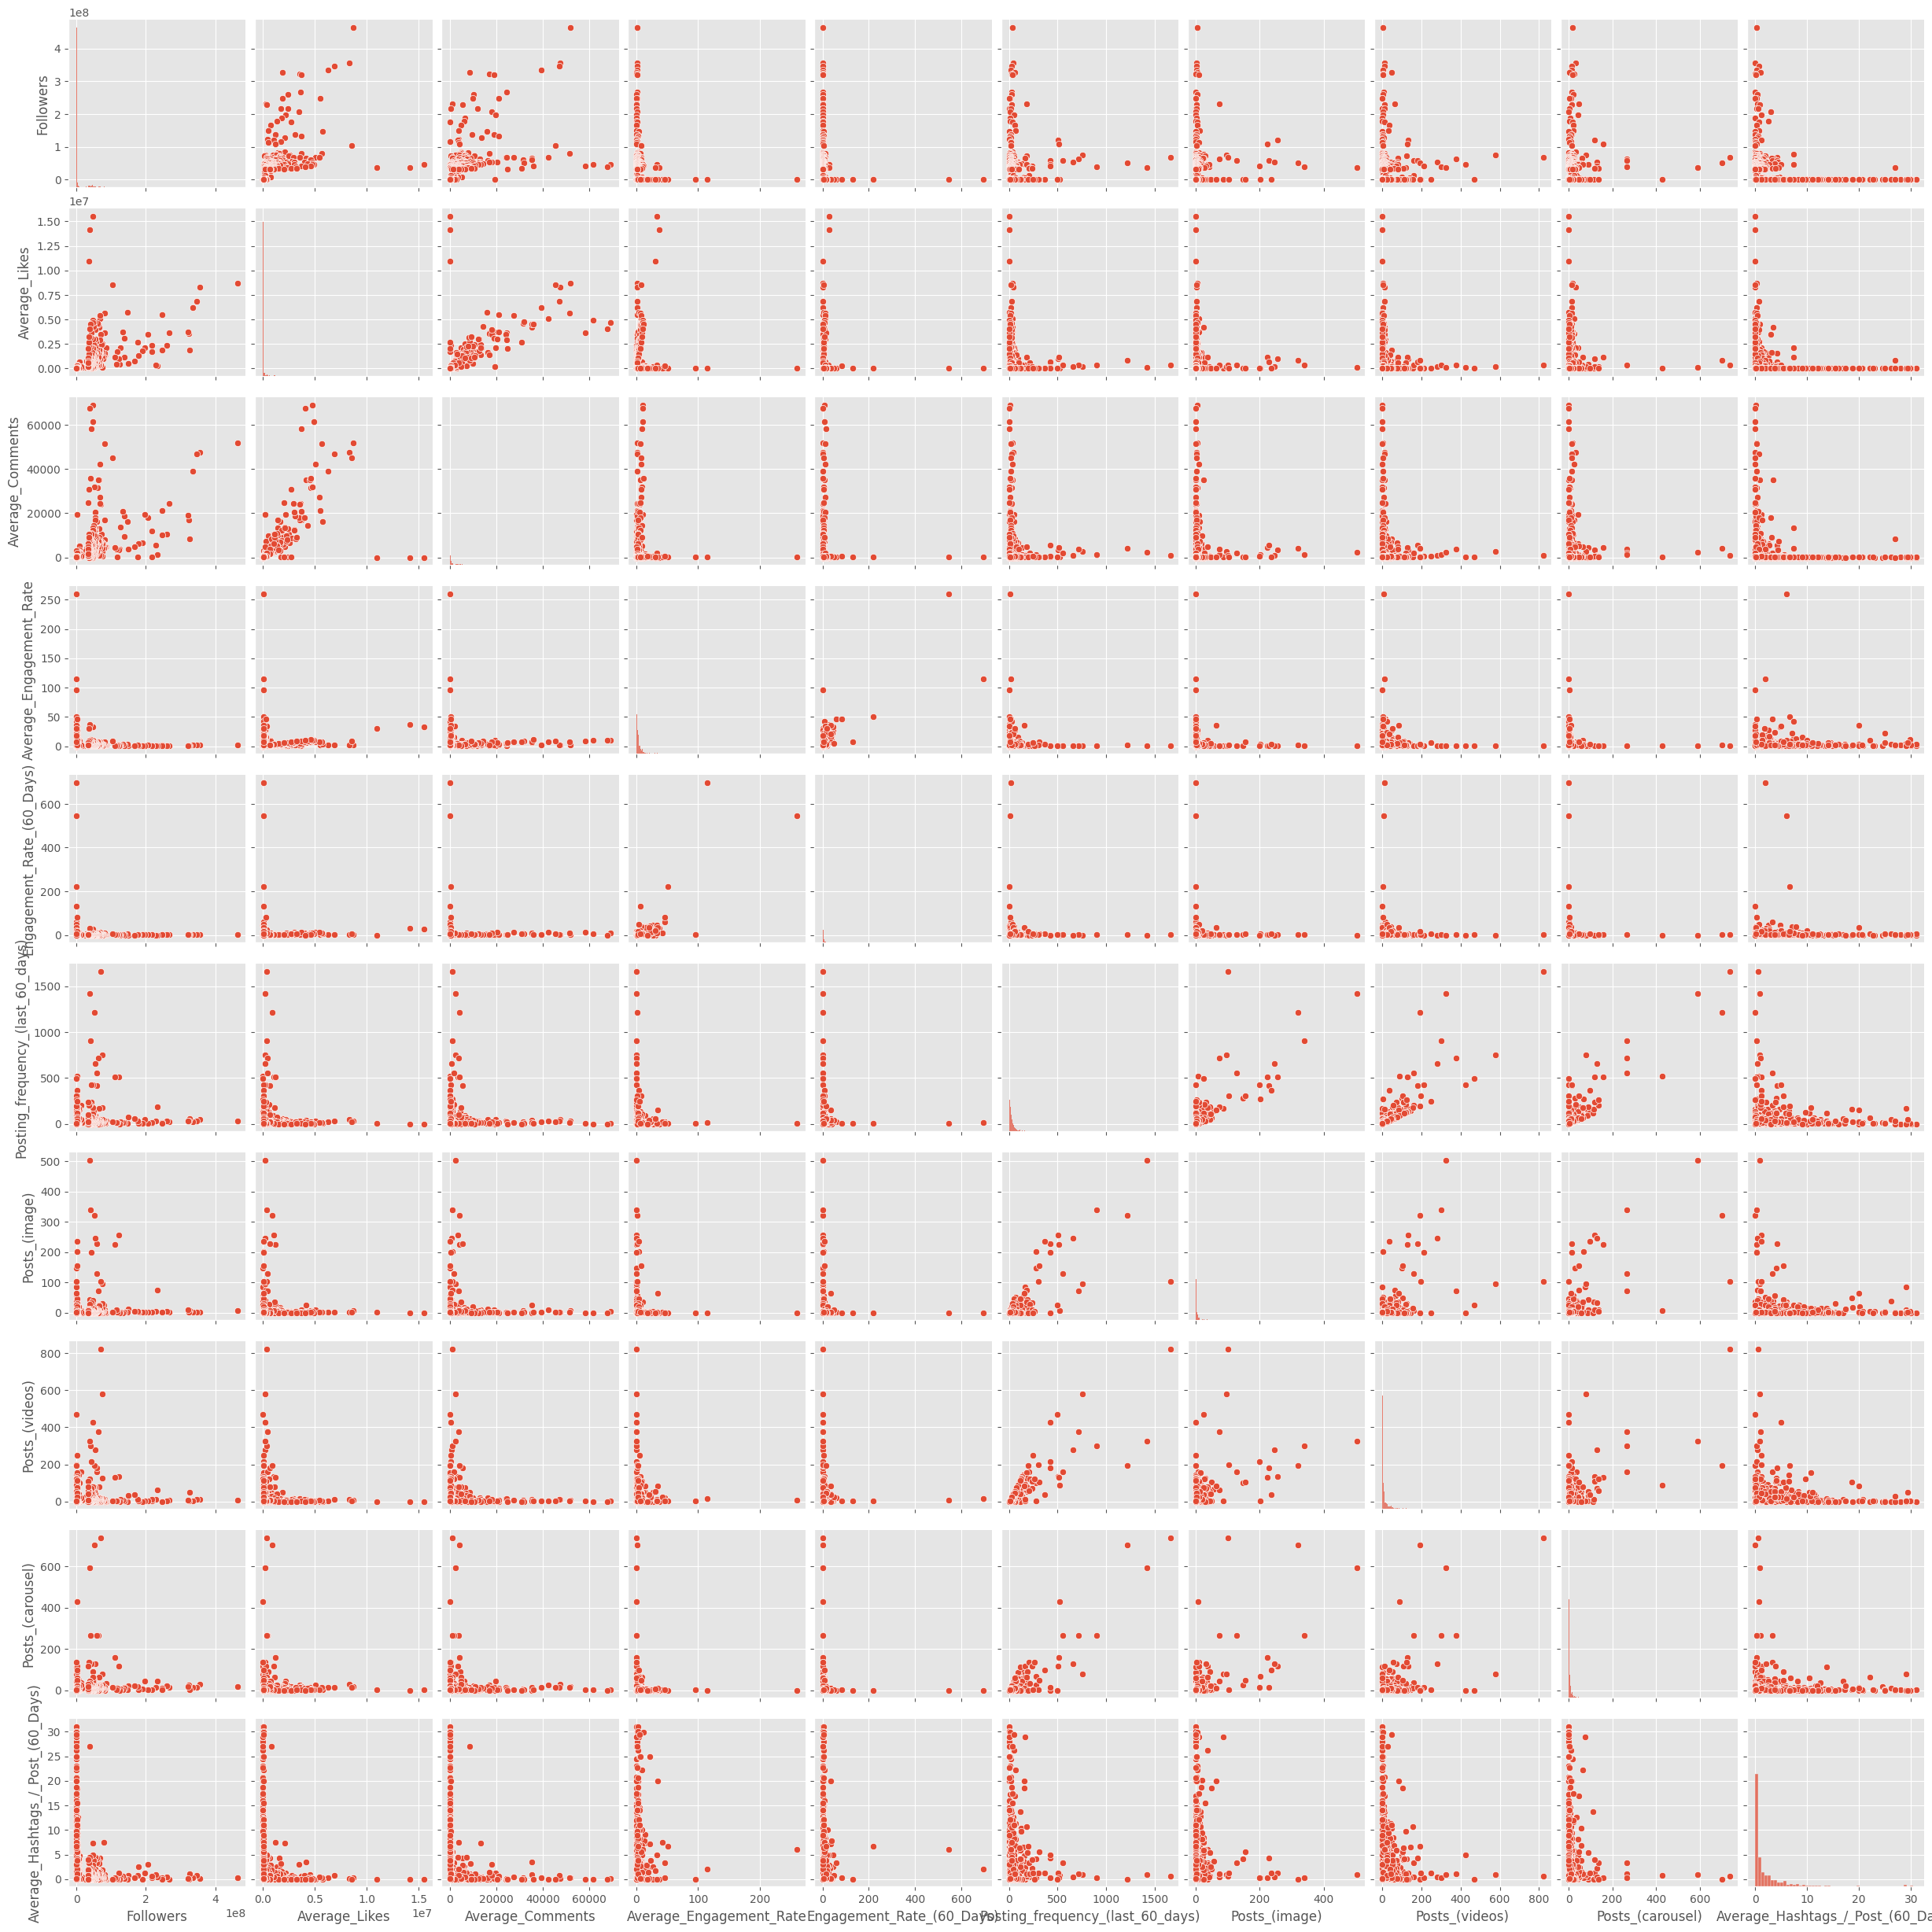

In [8]:
sns.pairplot(df[numeric_cols])
plt.show()


In [9]:
# Identify potential outliers
for col in numeric_cols:
    print(f'{col}:\nMin: {df[col].min()}, Max: {df[col].max()}')


Followers:
Min: 1021, Max: 465027234
Average_Likes:
Min: 0.0, Max: 15538683.0
Average_Comments:
Min: 0.0, Max: 69133.05
Average_Engagement_Rate:
Min: 0.0, Max: 260.116
Engagement_Rate_(60_Days):
Min: 0.0, Max: 697.4658
Posting_frequency_(last_60_days):
Min: 0.0, Max: 1660.0
Posts_(image):
Min: 0.0, Max: 503.0
Posts_(videos):
Min: 0.0, Max: 821.0
Posts_(carousel):
Min: 0.0, Max: 737.0
Average_Hashtags_/_Post_(60_Days):
Min: 0.0, Max: 31.0


In [6]:
# Calculate the number of outliers using the IQR rule
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)  # First quartile
    Q3 = df[col].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f'{col}: Number of outliers = {len(outliers)}')


Followers: Number of outliers = 207
Average_Likes: Number of outliers = 182
Average_Comments: Number of outliers = 185
Average_Engagement_Rate: Number of outliers = 71
Engagement_Rate_(60_Days): Number of outliers = 96
Posting_frequency_(last_60_days): Number of outliers = 88
Posts_(image): Number of outliers = 104
Posts_(videos): Number of outliers = 110
Posts_(carousel): Number of outliers = 77
Average_Hashtags_/_Post_(60_Days): Number of outliers = 97


In [25]:
from scipy.stats import zscore

# Calculate Z-scores for numeric columns
z_scores = df[numeric_cols].apply(zscore)

# Count outliers based on Z-scores
for col in z_scores.columns:
    num_outliers = (z_scores[col].abs() > 3).sum()  # Count rows with Z > 3 or Z < -3
    print(f'{col}: Number of outliers = {num_outliers}')


Followers: Number of outliers = 21
Average_Likes: Number of outliers = 20
Average_Comments: Number of outliers = 22
Average_Engagement_Rate: Number of outliers = 7
Engagement_Rate_(60_Days): Number of outliers = 4
Posting_frequency_(last_60_days): Number of outliers = 15
Posts_(image): Number of outliers = 14
Posts_(videos): Number of outliers = 14
Posts_(carousel): Number of outliers = 8
Average_Hashtags_/_Post_(60_Days): Number of outliers = 30


In [26]:
# Create a mask to filter out rows with outliers (Z-scores > 3 or < -3)
mask = (z_scores.abs() <= 3).all(axis=1)  # Keep rows where all columns have Z-scores <= 3

# Create a new DataFrame with outliers removed
df_cleaned_z = df[mask]

In [10]:
df_cleaned_iqr = df[(df['Average_Engagement_Rate'] >= lower_bound) & (df['Average_Engagement_Rate'] <= upper_bound) & (df['Engagement_Rate_(60_Days)'] >= lower_bound) & (df['Engagement_Rate_(60_Days)'] <= upper_bound)]

In [11]:
df_cleaned_iqr.shape

(755, 10)

Mean Squared Error: 1.7680738689463509
R-squared: 0.4337937618332819


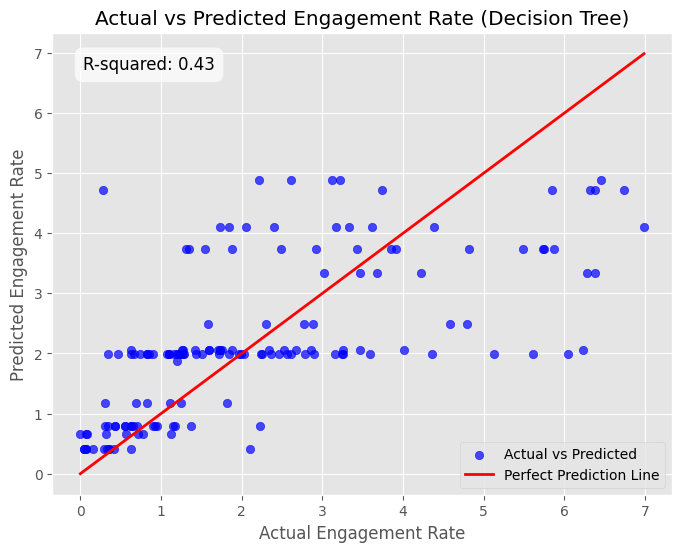

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming your dataframe is named `df`
X = df_cleaned_iqr.drop('Average_Engagement_Rate', axis=1)  # Independent variables (features)
y = df_cleaned_iqr['Average_Engagement_Rate']  # Dependent variable (target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Regressor model
model = DecisionTreeRegressor(max_depth=4,     # Minimum samples in leaf nodes
    random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plotting Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Actual vs Predicted')

# Perfect prediction line (where predicted = actual)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Prediction Line')

# Adding R-squared to the plot
plt.text(0.05, 0.95, f'R-squared: {r2:.2f}', horizontalalignment='left', verticalalignment='top', 
         transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

# Labeling axes
plt.title('Actual vs Predicted Engagement Rate (Decision Tree)')
plt.xlabel('Actual Engagement Rate')  # Actual values
plt.ylabel('Predicted Engagement Rate')  # Predicted values

# Display legend and grid
plt.legend()
plt.grid(True)
plt.show()

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Mean Squared Error: 0.3454467315940644
R-squared: 0.8893744781718743


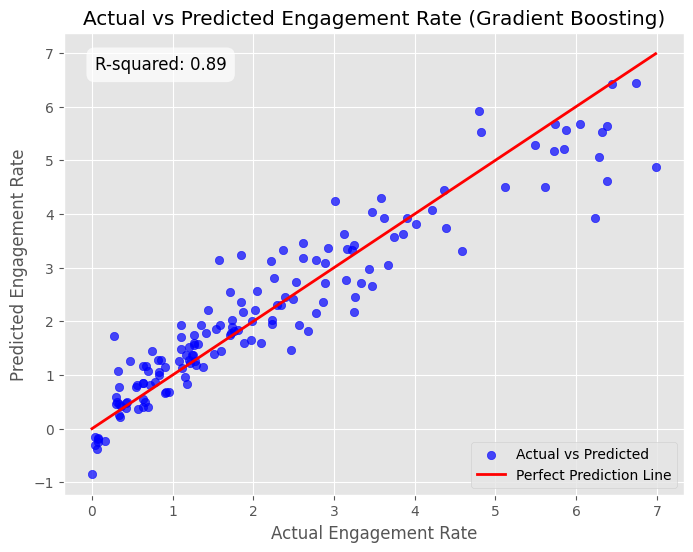

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Assuming your dataframe is named `df`
X = df_cleaned_iqr.drop('Average_Engagement_Rate', axis=1)  # Independent variables (features)
y = df_cleaned_iqr['Average_Engagement_Rate']  # Dependent variable (target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the GradientBoostingRegressor model
model = GradientBoostingRegressor(random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to tune parameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and train the model
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plotting Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Actual vs Predicted')

# Perfect prediction line (where predicted = actual)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Prediction Line')

# Adding R-squared to the plot
plt.text(0.05, 0.95, f'R-squared: {r2:.2f}', horizontalalignment='left', verticalalignment='top', 
         transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

# Labeling axes
plt.title('Actual vs Predicted Engagement Rate (Gradient Boosting)')
plt.xlabel('Actual Engagement Rate')  # Actual values
plt.ylabel('Predicted Engagement Rate')  # Predicted values

# Display legend and grid
plt.legend()
plt.grid(True)
plt.show()

Mean Squared Error: 1.6020553045447021
R-squared: 0.48695938373782055


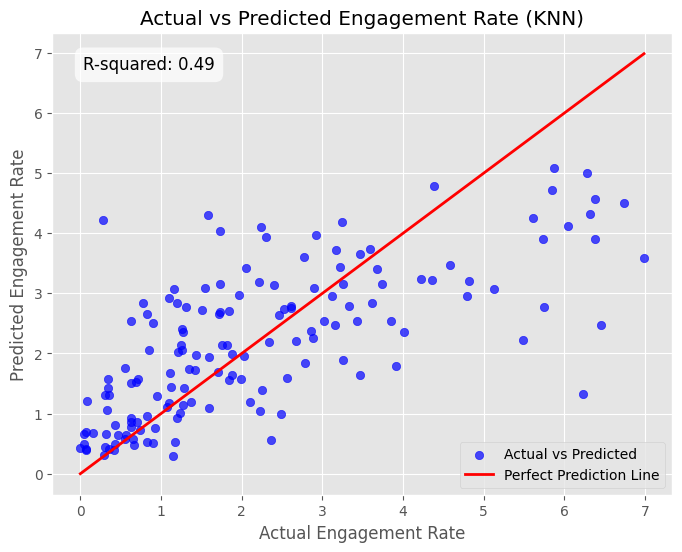

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming your dataframe is named `df`
X = df_cleaned_iqr.drop('Average_Engagement_Rate', axis=1)  # Independent variables (features)
y = df_cleaned_iqr['Average_Engagement_Rate']  # Dependent variable (target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Regressor model
model = KNeighborsRegressor(n_neighbors=4)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plotting Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Actual vs Predicted')

# Perfect prediction line (where predicted = actual)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Prediction Line')

# Adding R-squared to the plot
plt.text(0.05, 0.95, f'R-squared: {r2:.2f}', horizontalalignment='left', verticalalignment='top', 
         transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

# Labeling axes
plt.title('Actual vs Predicted Engagement Rate (KNN)')
plt.xlabel('Actual Engagement Rate')  # Actual values
plt.ylabel('Predicted Engagement Rate')  # Predicted values

# Display legend and grid
plt.legend()
plt.grid(True)
plt.show()

Mean Squared Error: 2.063226229259252
R-squared: 0.33927446003601847


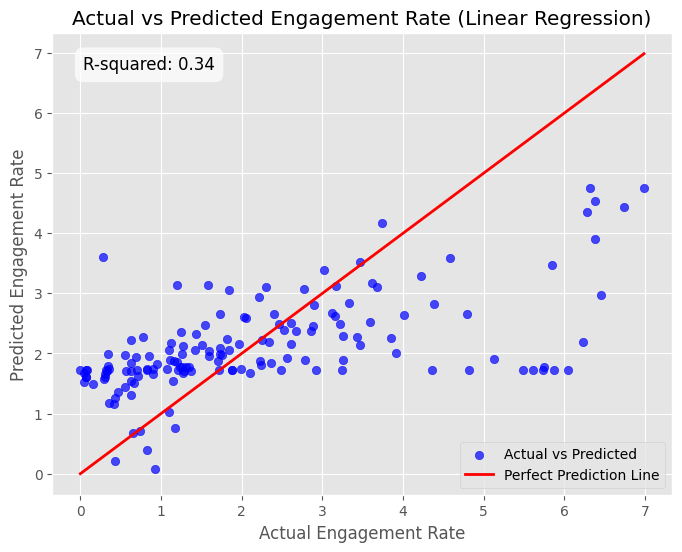

In [25]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming your dataframe is named `df`
X = df_cleaned_iqr.drop('Average_Engagement_Rate', axis=1)  # Independent variables (features)
y = df_cleaned_iqr['Average_Engagement_Rate']  # Dependent variable (target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared: {r2}')

# Plotting Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Actual vs Predicted')

# Perfect prediction line (where predicted = actual)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Prediction Line')

# Adding R-squared to the plot
plt.text(0.05, 0.95, f'R-squared: {r2:.2f}', horizontalalignment='left', verticalalignment='top', 
         transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

# Labeling axes
plt.title('Actual vs Predicted Engagement Rate (Linear Regression)')
plt.xlabel('Actual Engagement Rate')  # Actual values
plt.ylabel('Predicted Engagement Rate')  # Predicted values

# Display legend and grid
plt.legend()
plt.grid(True)
plt.show()

Mean Squared Error: 0.9420304233415964
R-squared: 0.6983251030361612


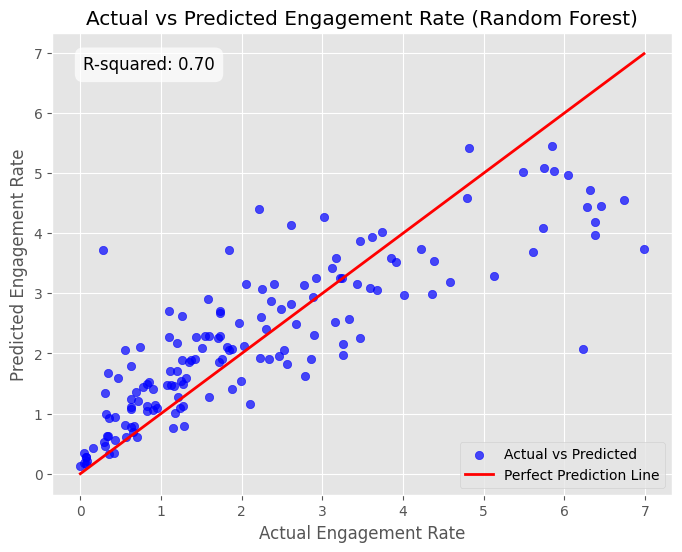

In [26]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming your dataframe is preprocessed and named `df_cleaned_z`
# Example for context (replace this with your actual dataframe loading/cleaning)
# df_cleaned_z = pd.read_csv('your_dataset.csv')  # Replace with actual data loading
# Ensure that 'Average_Engagement_Rate' exists in df_cleaned_z

# Define the features and target variable
X = df_cleaned_iqr.drop('Average_Engagement_Rate', axis=1)  # Independent variables (features)
y = df_cleaned_iqr['Average_Engagement_Rate']  # Dependent variable (target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plotting Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Actual vs Predicted')

# Perfect prediction line (where predicted = actual)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Prediction Line')

# Adding R-squared to the plot
plt.text(0.05, 0.95, f'R-squared: {r2:.2f}', horizontalalignment='left', verticalalignment='top', 
         transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

# Labeling axes
plt.title('Actual vs Predicted Engagement Rate (Random Forest)')
plt.xlabel('Actual Engagement Rate')  # Actual values
plt.ylabel('Predicted Engagement Rate')  # Predicted values

# Display legend and grid
plt.legend()
plt.grid(True)
plt.show()


Mean Squared Error: 0.37415283102181424
R-squared: 0.8801816651028638


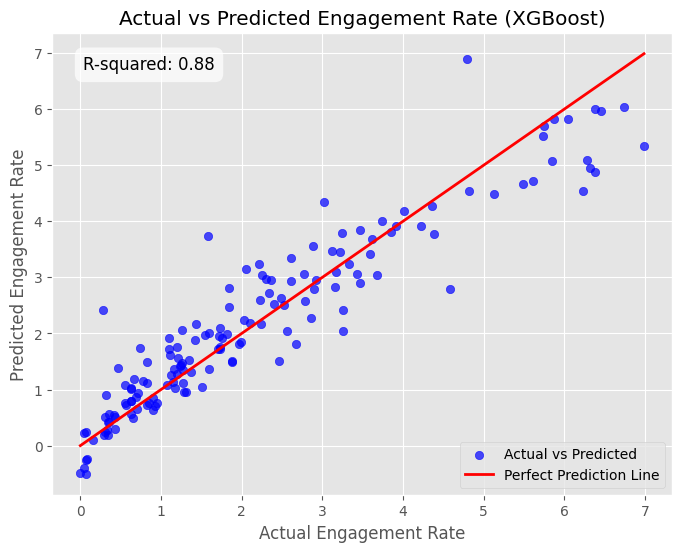

In [54]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Assuming your dataframe is named `df`
X = df_cleaned_iqr.drop('Average_Engagement_Rate', axis=1)  # Independent variables (features)
y = df_cleaned_iqr['Average_Engagement_Rate']  # Dependent variable (target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Regressor model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=350,
    max_depth=3,
    learning_rate=0.2,
    subsample=0.7,
    colsample_bytree=0.9
)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plotting Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Actual vs Predicted')

# Perfect prediction line (where predicted = actual)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Prediction Line')

# Adding R-squared to the plot
plt.text(0.05, 0.95, f'R-squared: {r2:.2f}', horizontalalignment='left', verticalalignment='top', 
         transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

# Labeling axes
plt.title('Actual vs Predicted Engagement Rate (XGBoost)')
plt.xlabel('Actual Engagement Rate')  # Actual values
plt.ylabel('Predicted Engagement Rate')  # Predicted values

# Display legend and grid
plt.legend()
plt.grid(True)
plt.show()